In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:

path_1 = 'dataset/HAM10000_images_part_1'
path_2 = 'dataset/HAM10000_images_part_2'
meta_path = 'dataset/HAM10000_metadata.csv'

metadata = pd.read_csv(meta_path)
image_folder = path_1

def load_images(metadata, image_folder):
    images = []
    labels = []
    for index, row in metadata.iterrows():
        image_path = os.path.join(image_folder, row['image_id'] + '.jpg')
        if os.path.exists(image_path):
            image = load_img(image_path, target_size=(128, 128))
            image = img_to_array(image)
            images.append(image)
            labels.append(row['dx'])
    return np.array(images), np.array(labels)

images_1, labels_1 = load_images(metadata, path_1)
images_2, labels_2 = load_images(metadata, path_2)

images = np.concatenate((images_1,images_2), axis=0)
labels = np.concatenate((labels_1,labels_2), axis=0)

# Encode labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
encoded_labels = np.array([label_mapping[label] for label in labels])
categorical_labels = to_categorical(encoded_labels)

# Split the data
train_images, test_images, train_labels, test_labels = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

In [4]:

# Build the CNN model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_images, train_labels,
    batch_size=32,
    epochs=50,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('diff_weights/custom_cnn_model_1.h5')


Epoch 1/50


2024-06-23 03:56:10.357228: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


188/188 [==============================] - 38s 199ms/step - loss: 1.0282 - accuracy: 0.6695 - val_loss: 0.9143 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 36s 190ms/step - loss: 0.9339 - accuracy: 0.6742 - val_loss: 0.9014 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 37s 196ms/step - loss: 0.8975 - accuracy: 0.6808 - val_loss: 0.8877 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - 35s 188ms/step - loss: 0.8647 - accuracy: 0.6946 - val_loss: 0.8294 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 5/50
188/188 [==============================] - 33s 174ms/step - loss: 0.8292 - accuracy: 0.6976 - val_loss: 0.7900 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - 35s 185ms/step - loss: 0.8043 - accuracy: 0.7076 - val_loss: 0.8166 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 7/50
188/188 [==============================] - 33s 176ms

In [5]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

accuracy = np.mean(y_pred_classes == y_true)
print(f'Accuracy on test data: {accuracy:.2f}')

63/63 [==============================] - 4s 59ms/step
Accuracy on test data: 0.75


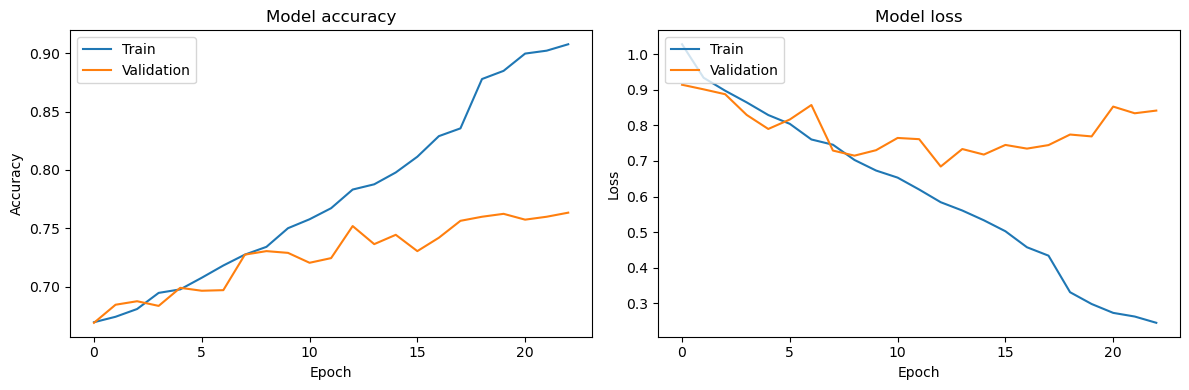

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


63/63 [==============================] - 4s 60ms/step


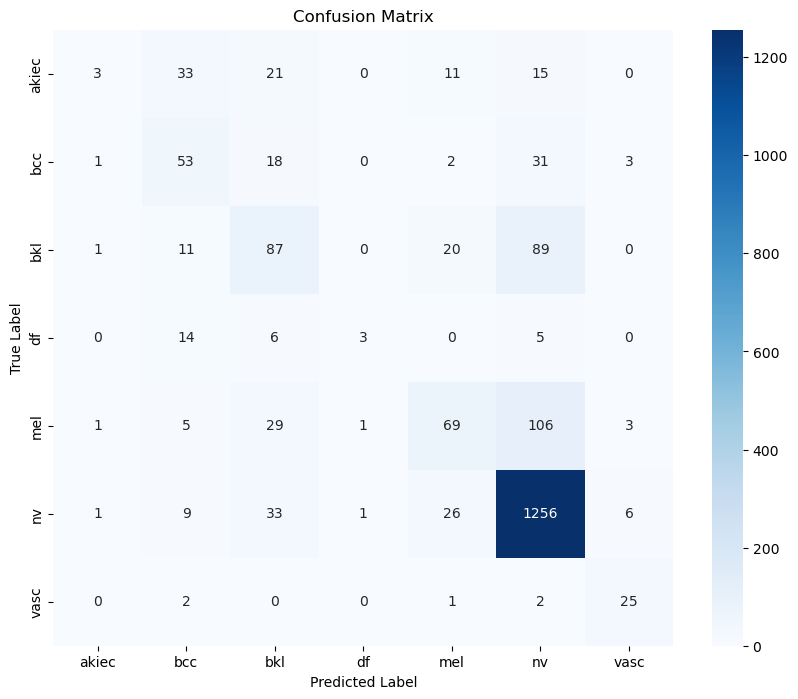

              precision    recall  f1-score   support

       akiec       0.43      0.04      0.07        83
         bcc       0.42      0.49      0.45       108
         bkl       0.45      0.42      0.43       208
          df       0.60      0.11      0.18        28
         mel       0.53      0.32      0.40       214
          nv       0.84      0.94      0.89      1332
        vasc       0.68      0.83      0.75        30

    accuracy                           0.75      2003
   macro avg       0.56      0.45      0.45      2003
weighted avg       0.72      0.75      0.72      2003



In [7]:

# Predict the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
class_report = classification_report(y_true, y_pred_classes, target_names=label_mapping.keys())
print(class_report)


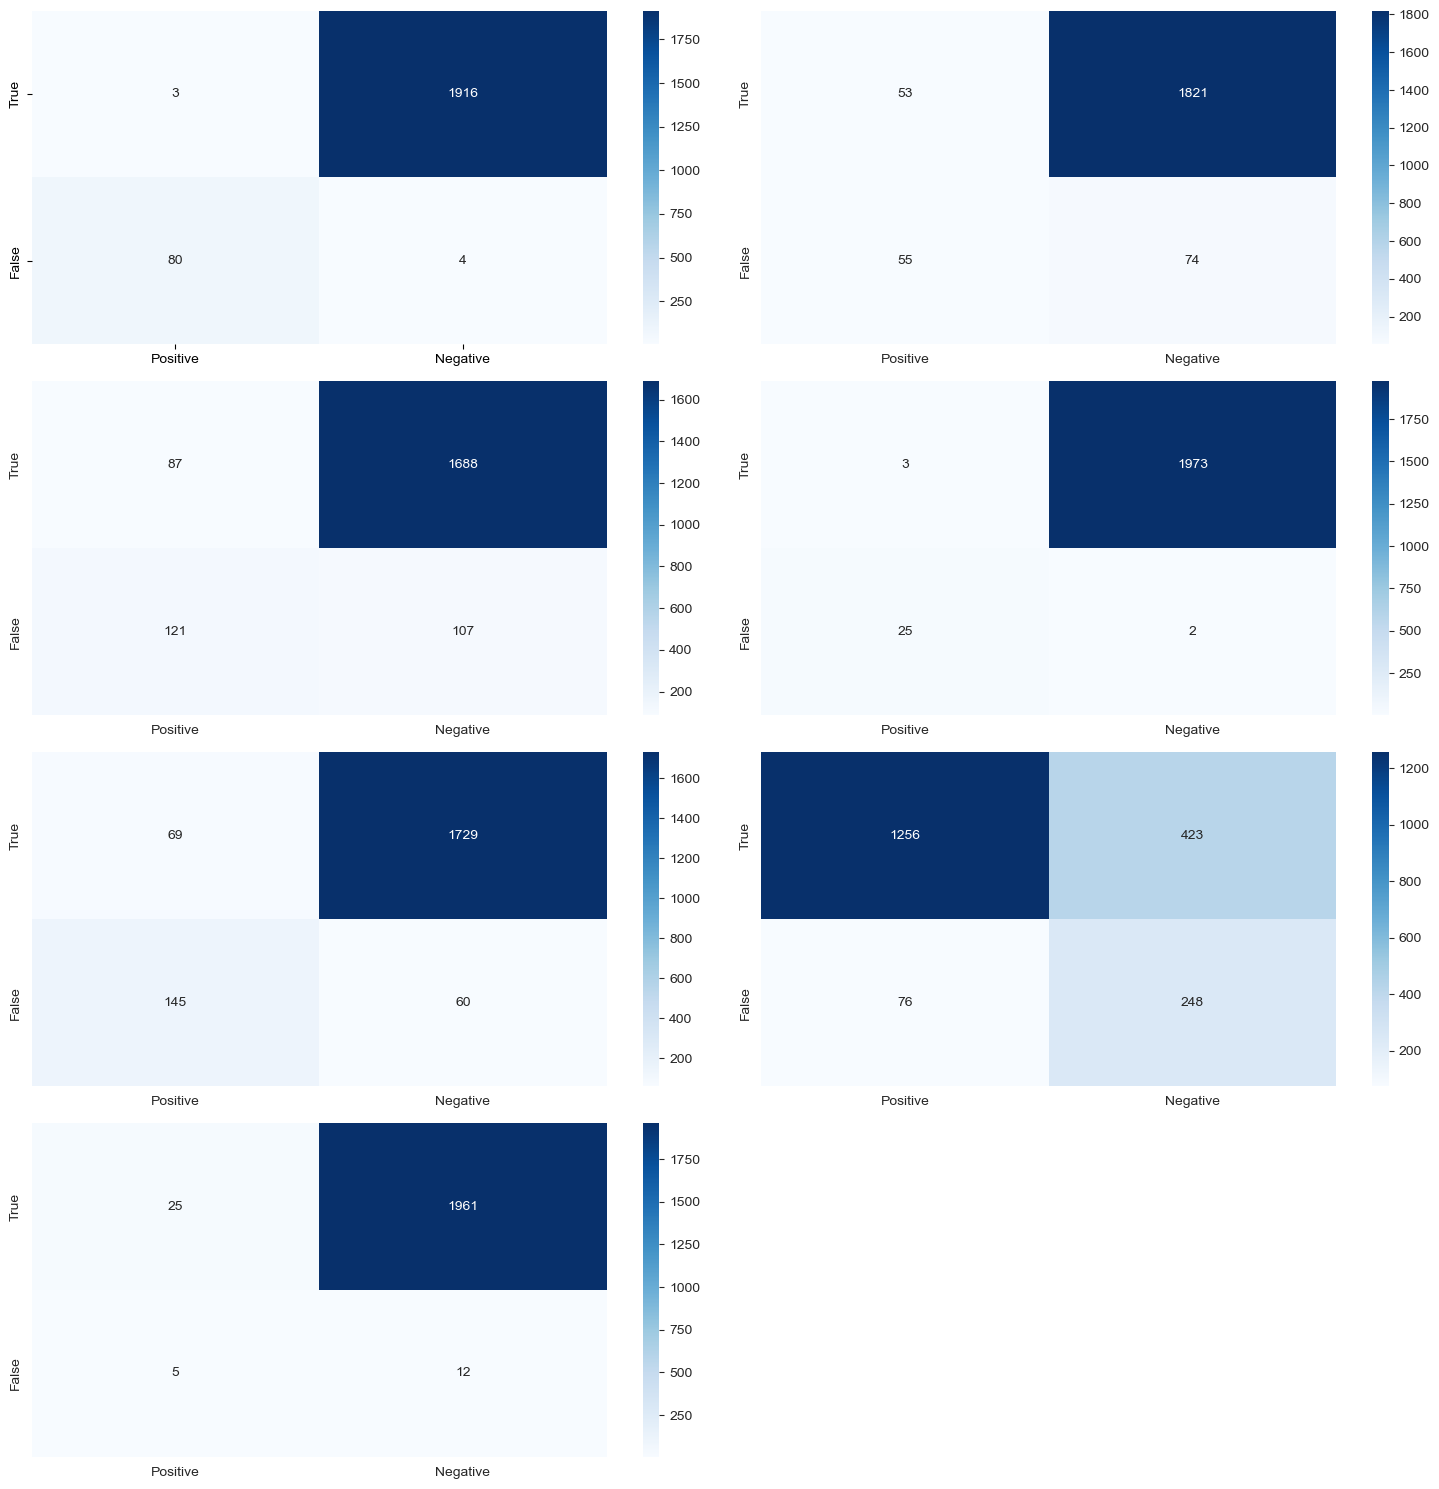

In [8]:
plt.figure(figsize=(15,15))
for i in range(7):
    plt.subplot(4,2,i+1)
    true_positives = conf_matrix[i,i]
    true_negatives = np.sum(conf_matrix) - np.sum(conf_matrix[i,:]) - np.sum(conf_matrix[:,i]) + true_positives
    false_positives = conf_matrix[i,:].sum() - true_positives
    false_negatives = conf_matrix[:,i].sum() - true_positives
    mat = [[true_positives,true_negatives],[false_positives,false_negatives]]
    sns.set_style('darkgrid') 
    plt.gca().set_frame_on(True)
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive','Negative'], yticklabels=['True','False'])
plt.tight_layout()
plt.show()